In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

## Init env.

state vector dim = 8
n_actions = 4


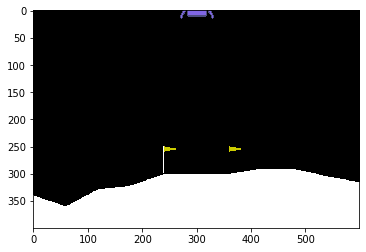

In [2]:
# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("LunarLander-v2").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

## Init agent.

In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

## Functions.

In [8]:
def generate_session(agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])
        probs = np.reshape(probs, (n_actions, ))

        assert probs.shape == (n_actions,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(n_actions, 1, p=probs)[0]
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)
        print(r)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward


def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states, elite_actions = [], []

    for (i, st, act) in zip(range(len(rewards_batch)), 
                                  states_batch,
                                  actions_batch):
        [(elite_states.append(s), elite_actions.append(a))
         for s, a in zip(st, act)
         if rewards_batch[i] >= reward_threshold]

    return elite_states, elite_actions


def show_progress(iteration, 
                  rewards_batch, 
                  log, percentile, 
                  reward_range=[+100, +140]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("iter = %d, mean reward = %.3f, threshold=%.3f" % (iteration, 
                                                             mean_reward, 
                                                             threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

## Train agent.

iter = 2, mean reward = -4.907, threshold=3.301


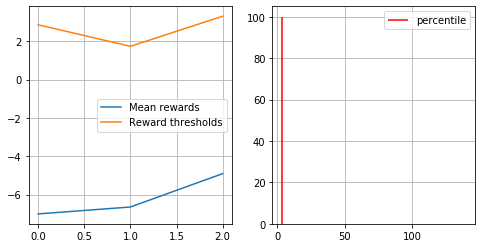

0.6352800998601253
0.6439030471612739
1.5234066368760761
-1.944226295866389
1.8301164975595736
2.0057534515557633
-1.7992640081898117
1.2172453267541528
2.182700582417057
2.3159524093972563
-0.48941006041533686
0.23060031992983454
0.1097397150212771
-0.99640322241268
-0.6124024649011222
-0.3733095221441431
-0.7874961290014995
0.2994790942198051
0.16234006939058077
0.021293833668693196
-0.9650041343372209
0.2488377967769975
-0.08237792248288997
0.19032162639715125
-0.6327642695423492
0.017126064555566256
1.260121850067503
0.4024289348700745
-0.4542345292473442
1.1427120109548923
0.7166102352111079
0.5327166617481975
0.9529407718191021
1.1896963453575335
-0.7211218086108306
2.2209460512827777
1.2623892088996354
-1.2273352678687093
-1.5922872068429388
-0.4901732470016771
-0.5142104326307038
-1.873904500336322
-0.45149335553980907
-0.2730550587621383
-0.7840359146202331
-0.20434043760491136
2.0716668919406915
0.017761559913283237
5.351786371653032
-1.1921877107751016
1.1803095584807124
2.6

KeyboardInterrupt: 

In [9]:
n_sessions = 20
percentile = 80
log = []

for i in range(50):
    # generate new sessions
    sessions = (generate_session(agent, n_sessions) 
                for _ in range(100))

    states_batch, actions_batch, rewards_batch = \
        map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, 
                                                actions_batch, 
                                                rewards_batch, 
                                                percentile)

    # <partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, 
                      elite_actions)

    show_progress(i,
                  rewards_batch, 
                  log, 
                  percentile, 
                  reward_range=[100, 140])

    if np.mean(rewards_batch) >= 200:
        print("You Win! You may stop training now via KeyboardInterrupt.")

iter = 9, mean reward = -135.555, threshold=-90.467


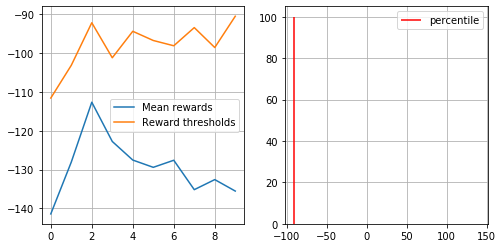

KeyboardInterrupt: 

In [5]:
n_sessions = 200
percentile = 70
log = []

for i in range(200):
    # generate new sessions
    sessions = (generate_session(agent, n_sessions) 
                for _ in range(100))

    states_batch, actions_batch, rewards_batch = \
        map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, 
                                                actions_batch, 
                                                rewards_batch, 
                                                percentile)

    # <partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, 
                      elite_actions)

    show_progress(i,
                  rewards_batch, 
                  log, 
                  percentile, 
                  reward_range=[100, 140])

    if np.mean(rewards_batch) >= 200:
        print("You Win! You may stop training now via KeyboardInterrupt.")

## Results.

In [27]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("LunarLander-v2"),
                           directory="videos", force=True)
sessions = [generate_session(agent) for _ in range(100)]
env.close()

## Videos.

In [28]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [29]:
print(video_names[-1])

openaigym.video.0.24832.video000001.mp4
